In [1]:
# import required dependencies
import pandas as pd
from tensorflow.data import Dataset
import os
from tensorflow.keras import layers
from sklearn.preprocessing import OrdinalEncoder
from preprocess import get_interesting_idx,load_data
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
od_encode = OrdinalEncoder()

In [4]:
data = pd.read_excel("19 action.xlsx")
data = data.query('sign == ["thankyou","happy","hello","mom","dad"]')
od_encode.fit(data[['sign']])
data['sign'] = od_encode.transform(data[["sign"]])[:,0].astype(int)
data['source'] = data['path'] + "$" +data['sign'].astype('str')
data.head()

,path,participant_id,sequence_id,sign,source
7,train_landmark_files/30680/1005102931.parquet,30680,1005102931,4,train_landmark_files/30680/1005102931.parquet$4
11,train_landmark_files/22343/1006778422.parquet,22343,1006778422,1,train_landmark_files/22343/1006778422.parquet$1
17,train_landmark_files/32319/1011764636.parquet,32319,1011764636,0,train_landmark_files/32319/1011764636.parquet$0
18,train_landmark_files/37055/1011888729.parquet,37055,1011888729,1,train_landmark_files/37055/1011888729.parquet$1
26,train_landmark_files/27610/1016834986.parquet,27610,1016834986,4,train_landmark_files/27610/1016834986.parquet$4


In [5]:
n_class = data.sign.nunique()

In [6]:
X_train, X_test, y_train,y_test = train_test_split(data['source'],data['sign'],test_size=0.2,random_state=10,stratify=data['sign'])

In [7]:
X_test, X_val, y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=10,stratify=y_test,shuffle=True)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1519,)
(190,)
(190,)


In [9]:
idx = get_interesting_idx()

In [10]:
def data_loarder(source):
    source = source.numpy().decode()
    ld = load_data(idx)
    data,label = ld.load_relavent_data(source,n_class,"$")
    return data,label

In [11]:
def map_function(source):
    return tf.py_function(data_loarder,[source],(tf.float64,tf.float64))

In [12]:
train_ds = Dataset.from_tensor_slices(X_train)
train_ds = train_ds.map(map_function)
train_ds = train_ds.padded_batch(10,padded_shapes=([None,None,None],[n_class]))

In [13]:
test_ds = Dataset.from_tensor_slices(X_test)
test_ds = test_ds.map(map_function)
test_ds = test_ds.padded_batch(10,padded_shapes=([None,None,None],[n_class]))

In [14]:
val_ds = Dataset.from_tensor_slices(X_val)
val_ds = val_ds.map(map_function)
val_ds = val_ds.padded_batch(10,padded_shapes=([None,None,None],[n_class]))

Build model

In [15]:
from resnet import add_residual_block,data_augmentation
from tensorflow.keras.layers import Dropout,Conv2D,MaxPool2D,GlobalAveragePooling2D,Dense,BatchNormalization,ReLU
from tensorflow.keras.callbacks import TensorBoard

In [16]:
log_dir = os.path.join('Logs_1')
tb_callback = TensorBoard(log_dir=log_dir)

In [17]:
Input_shape = (None,160,80,3)
Input = tf.keras.layers.Input(shape=Input_shape[1:])
x = Input

x = Conv2D(16,(3,3),padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D(pool_size=(3,3),strides=(1,1))(x)

x = data_augmentation()(x)

#Block 1
x = add_residual_block(x,16,(3,3))
x = MaxPool2D(pool_size=(3,3),strides=(2,2))(x)
x = Dropout(0.25)(x)

# Block 2
x = add_residual_block(x,32,(3,3))
x = MaxPool2D(pool_size=(3,3),strides=(2,2))(x)
x = Dropout(0.25)(x)

#Block 3
x = add_residual_block(x,32,(3,3))
x = MaxPool2D(pool_size=(3,3),strides=(2,2))(x)
x = Dropout(0.25)(x)

x = Conv2D(16,(3,3),padding='same')(x)
x = MaxPool2D(pool_size=(3,3),strides=(2,2))(x)

x = GlobalAveragePooling2D()(x)
x = Dense(n_class,activation='softmax')(x)

model = tf.keras.Model(Input,x)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 80, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 160, 80, 16)  448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 80, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [29]:
model.fit(train_ds,epochs=50,validation_data=val_ds,callbacks=[tb_callback])

Layer Residual_main has arguments ['filter', 'kernel_size']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/50
152/152 [==============================] - 25s 165ms/step - loss: 0.2225 - accuracy: 0.9203 - val_loss: 0.7276 - val_accuracy: 0.8158
Epoch 2/50
152/152 [==============================] - 24s 155ms/step - loss: 0.2371 - accuracy: 0.9098 - val_loss: 0.7136 - val_accuracy: 0.8421
Epoch 3/50
152/152 [==============================] - 25s 162ms/step - loss: 0.2097 - accuracy: 0.9157 - val_loss: 0.6481 - val_accuracy: 0.8421
Epoch 4/50
152/152 [==============================] - 23s 154ms/step - loss: 0.2372 - accuracy: 0.91

In [30]:
model.evaluate(test_ds)

19/19 [==============================] - 2s 84ms/step - loss: 0.7574 - accuracy: 0.8105


[0.7573918104171753, 0.8105263113975525]

In [37]:
model.save("5_action_v2_acc_94_valacc_81")

INFO:tensorflow:Assets written to: 5_action_v2_acc_94_valacc_81\assets


INFO:tensorflow:Assets written to: 5_action_v2_acc_94_valacc_81\assets


In [31]:
act_pred = []
for values in test_ds:
    y_pred = model.predict(values[0])
    y_pred = list(map(lambda X:np.argmax(X),y_pred))
    act = list(map(lambda X:np.argmax(X),values[1]))
    for value in  zip(act,y_pred):
        act_pred.append(value)


1/1 [==============================] - 0s 67ms/step


In [32]:
evaluation = pd.DataFrame(act_pred,columns=["Actual","Predict"])
evaluation.head()

,Actual,Predict
0,2,2
1,1,1
2,1,1
3,2,0
4,3,3


In [26]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

In [33]:
print(classification_report(evaluation["Actual"],evaluation["Predict"]))

              precision    recall  f1-score   support

           0       0.64      0.97      0.77        38
           1       0.79      0.79      0.79        38
           2       1.00      0.72      0.84        39
           3       1.00      0.82      0.90        40
           4       0.79      0.74      0.76        35

    accuracy                           0.81       190
   macro avg       0.84      0.81      0.81       190
weighted avg       0.85      0.81      0.81       190



<Axes: >

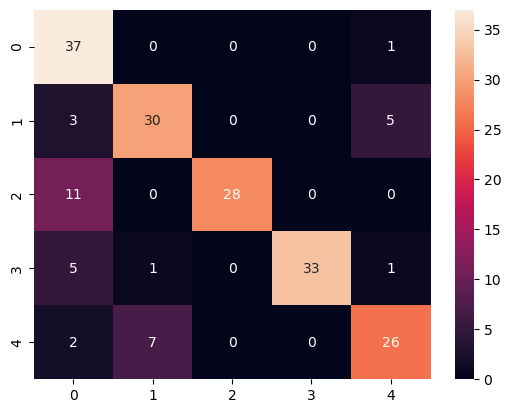

In [34]:
sns.heatmap(confusion_matrix(evaluation["Actual"],evaluation["Predict"]),annot=True)

In [35]:
import pickle

In [39]:
with open("Label_encoder_5.pkl",'wb') as file:
    pickle.dump(od_encode,file)